Test Function


First cell: I defined the parameters like the dimensions of field, the number of stars and exponent of the potential laws and the IMF function

In [378]:
# FIRST CELL
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from scipy.signal import fftconvolve, convolve
#import cython as cpy

'''
Funzioni che devo implementare:
	- generazione	IMF  = (m/m0)^-alpha	alpha = 2
	  distrubuzione	m/m0 = IMF^(-1/alpha)
	  m in [0.1,20]
	- luminosità	L/L0 = (m/m0)^beta	beta  = 3
	- 

'''
# dimension of the matrix
N = int(1e2)
# number of stars
M = int(1e2)

# Set parameters
alpha = 2
beta  = 3
m_min = 0.1; m_max = 20

IMF = lambda m : m**(-alpha)
IMF_min = IMF(0.1); IMF_max = IMF(20) 




Second and Third cells: I defined the function for the random generation of the masses and I created the luminosity array

0.10000112661937935 8.536759192732472


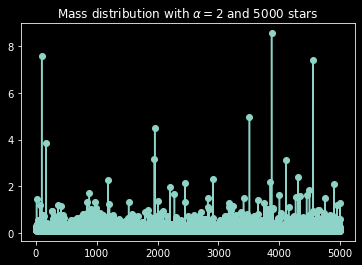

In [173]:
# SECOND CELL
##* Genration of masses array with IMF distribution
#	param	min	minimum imf value
# 	param	max	maximum	imf value
# 
# 	return	m	M array of masses distributed like imf   
def generate_mass_array(min,max):
	np.random.seed()
	imf = np.random.rand(M)*(max-min)+min
	return imf**(-1/alpha)

# masses
m = generate_mass_array(IMF_min,IMF_max)


# Plot data
print(min(m), max(m))

plt.title(f'Mass distribution with $\\alpha = {alpha}$ and {M} stars')
plt.plot(m,'o-')

plt.show()



0.0010000000000000002 8000
0.0010000337989621634 622.1270612705742


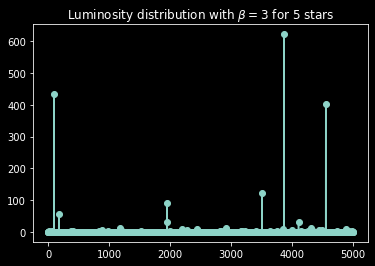

In [271]:
# THIRD CELL
# luminosuities
L = m**beta

# Plot data
print(0.1**beta,20**beta)
print(min(L), max(L))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
plt.plot(L,'o-')

plt.show()

Fourth cell: I defined the star class obj, a class that contains all infos about star (mass,lum and position), the function to set stars positions and the function to update the field matrix with the stars luminosities in mag

In [370]:
# FOURTH CELL
##* Star class obj
class star(object):
#		param	mass	star mass
#		param	lum	star luminosity
# 		param	x,y 	star coordinates in the field 	
	def __init__(self,mass, lum, x ,y):
		self.m   = mass		# star mass value
		self.lum = lum		# star luminosity value
		self.x = x		# star x coordinate
		self.y = y		# star y coordinate

##* Function to locate the stars
#   It generates 2 arrays with the x and y position of each star
#?  Da rigurdare bene
#	param	n	number of stars
#
#	return	X,Y	stars coordinate arrays
def star_location(n):
	tmp = np.random.default_rng()
	X = tmp.choice(N, size=n)
	Y = tmp.choice(N, size=n)#, replace=False)
	return X, Y	

##* Transfer function
#   Converts luminosities in a scale from 0 to 1 for the function
#   plt.imshow()
# 	param	l	luminosity array
# 
# 	return	mag	converted magnitudes array   
def transfer_function(l):
	inf = 9e-5; sup = 8000
	tmp = np.where(l==0,inf,l)
	mag = (np.log10(tmp)-np.log10(inf))/(np.log10(sup)-np.log10(inf))
	return np.where(mag<0,0,mag)

def inverse_transfer_function(mag):
	sup = 8000
	val = sup**mag
	return np.where(val==1.,0,val)



##* Function to update field with the stars
#	param	F	field matrix
#	param	X,Y	coordinate arrays
#	param	l	luminosity array
# 
# 	return	F	updated field matrix 
def exposure(F,X,Y,l):
	mag = transfer_function(l)
	for i in range(3):
		F[X,Y,i] = mag
	# for i in range(dim):
	# 	F[X[i],Y[i],:] = transfer_function(val[i])
	return F



Fifth cell: I defined the inizialize function to set stars in field and the fov function to select a portion of the field

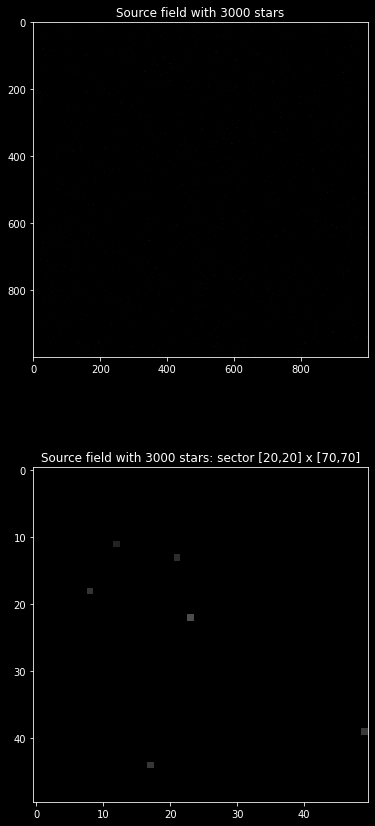

In [367]:
# FIFTH CELL

def initialize():
	F = np.zeros([N,N,3])
	m = generate_mass_array(IMF_min,IMF_max)
	L = m**beta
	xs,ys = star_location(M)
#	print(xs,ys)
	F = exposure(F,xs,ys,L)
	S = star(m,L,xs,ys)
	return F, S

def fov(F,inf=[0,0],sup=[int(N/3),int(N/3)]):
	if((inf[0]<0) or (inf[1]<0) or (sup[0]>=N) or (sup[1]>=N)):
		print('Error')
		return F
	return F[inf[0]:sup[0],inf[1]:sup[1],:] 

F, S = initialize()
Ls = S.lum
inf = [20,20]
sup = [70,70]
field = fov(F,inf,sup)

fig, (img_field, img_zoom) = plt.subplots(2,1,figsize=(6,15))
img_field.imshow(F)
img_field.set_title(f'Source field with {M} stars')
img_zoom.imshow(field)
img_zoom.set_title(f'Source field with {M} stars: sector [{inf[0]},{inf[1]}] x [{sup[0]},{sup[1]}]')
plt.show()

Sixth cell: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


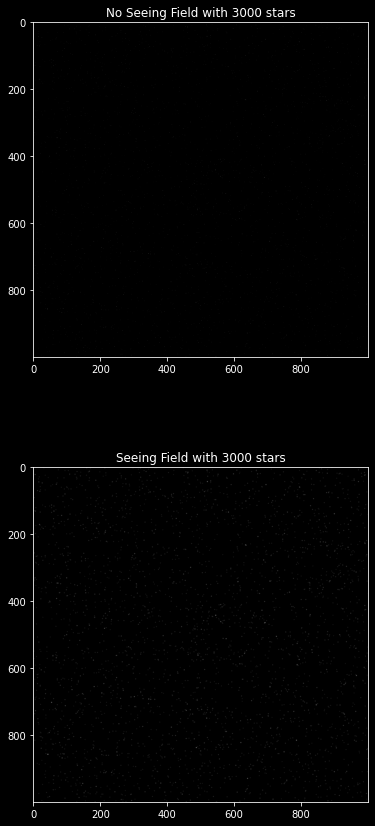

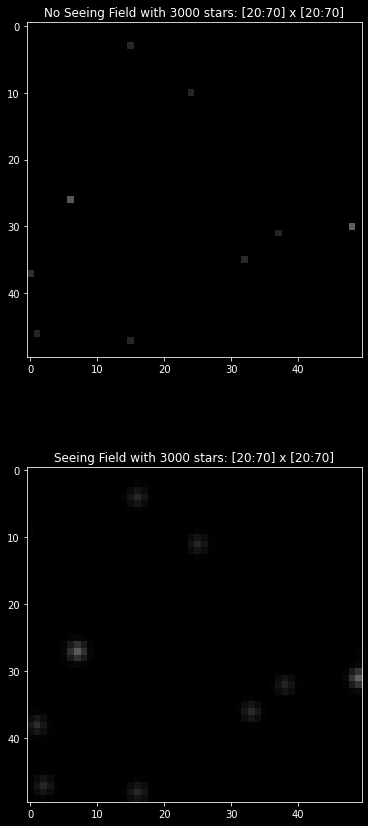

In [368]:
# SIXTH CELL
def gaussian(n,xs,ys,sigma=0.9):
	x = np.arange(n,dtype=int)
	y = np.arange(n,dtype=int)
	x -= xs;  y -= ys
	G = lambda r : np.exp(-r**2/sigma**2/2)#/np.sqrt(np.pi)
	return np.outer(G(x),G(y))


def atm_seeing(f):
	n = len(f)
	field = f[:,:,0]
#	field = inverse_transfer_function(field)
	field = fftconvolve(field,gaussian(n,int(n/2),int(n/2)),mode='same')
#	field = transfer_function(field)
	for i in range(3):
		f[:,:,i] = field
	return f

fig1, (img_field, img_field_seeing) = plt.subplots(2,1,figsize=(6,15))
fig2, ( img_zoom, img_zoom_seeing)  = plt.subplots(2,1,figsize=(6,15))

F, S = initialize()
img_field.imshow(F)
img_field.set_title(f'No Seeing Field with {M} stars')
img_zoom.imshow(F[20:70,20:70,:])
img_zoom.set_title(f'No Seeing Field with {M} stars: [20:70] x [20:70]')

F_s = atm_seeing(F)
img_field_seeing.imshow(F_s)
img_field_seeing.set_title(f'Seeing Field with {M} stars')
img_zoom_seeing.imshow(F_s[20:70,20:70,:])
img_zoom_seeing.set_title(f'Seeing Field with {M} stars: [20:70] x [20:70]')

fig1.savefig('./Pictures/field.png')
fig2.savefig('./Pictures/zoom.png')

plt.show()
	
	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


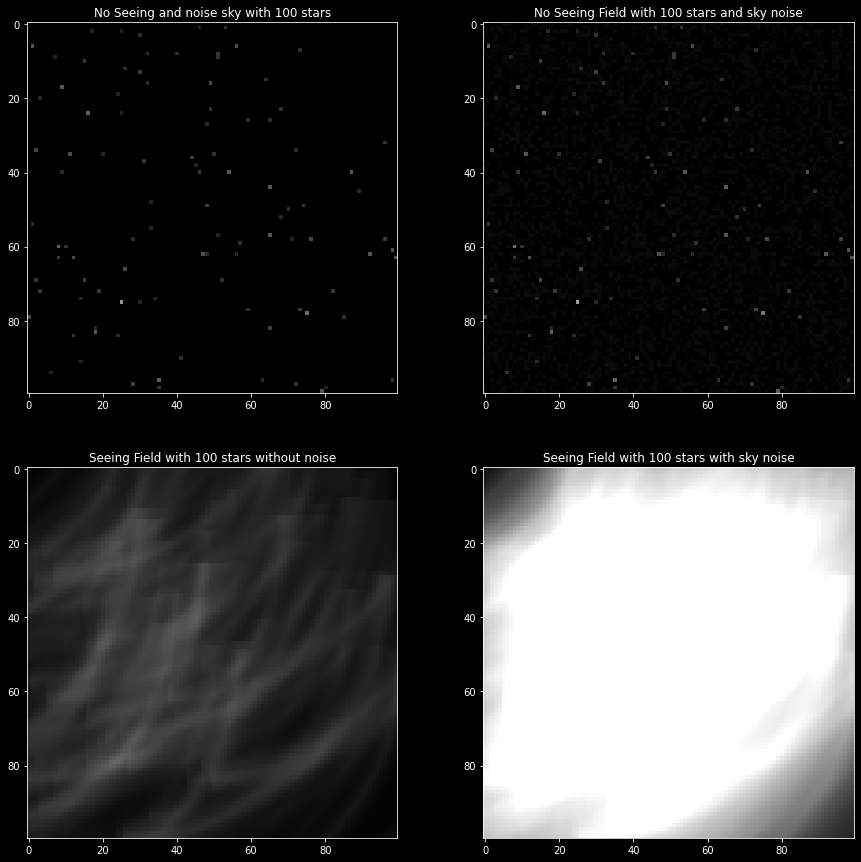

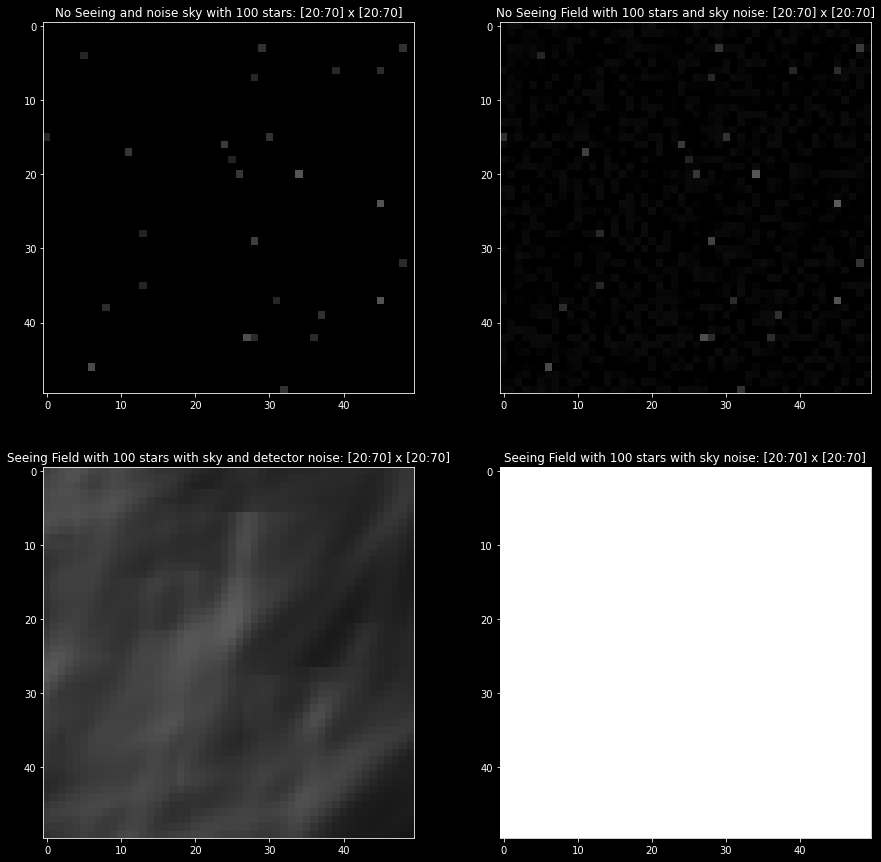

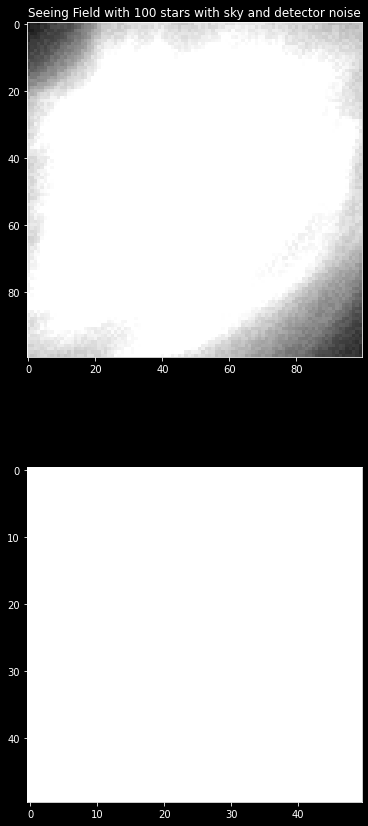

In [379]:

def noise(n = 2e-4):
	np.random.seed()
	N0 = np.random.random((N,N))
	Noise = np.zeros([N,N,3])
	Noise[:,:,0] = N0*n
	for i in range(1,3):
		Noise[:,:,i] = Noise[:,:,0]
	return Noise



F, S = initialize()

F_n = F + transfer_function(noise())

inf = int(0.2*N)
sup = int(0.7*N)

fig1, ((img_field, img_field_noise),(img_field_seeing,img_field_snoise)) = plt.subplots(2,2,figsize=(15,15))
fig2, ((img_zoom, img_zoom_noise)  ,(img_zoom_seeing,img_zoom_snoise))   = plt.subplots(2,2,figsize=(15,15))
fig3, (img_field_tot, img_zoom_tot) = plt.subplots(2,1,figsize=(6,15))


img_field.imshow(F)
img_field.title.set_text(f'No Seeing and noise sky with {M} stars')
img_zoom.imshow(F[inf:sup,inf:sup,:])
img_zoom.title.set_text(f'No Seeing and noise sky with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')


img_field_noise.imshow(F_n)
img_field_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise')
img_zoom_noise.imshow(F_n[inf:sup,inf:sup,:])
img_zoom_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise: [{inf}:{sup}] x [{inf}:{sup}]')

F_s = atm_seeing(F)
#F_s += transfer_function(noise(1e-3))
img_field_seeing.imshow(F_s)
img_field_seeing.title.set_text(f'Seeing Field with {M} stars without noise')
img_zoom_seeing.imshow(F_s[inf:sup,inf:sup,:])
img_zoom_seeing.title.set_text(f'Seeing Field with {M} stars without noise: [{inf}:{sup}] x [{inf}:{sup}]')

F_sn = atm_seeing(F_n)
img_field_snoise.imshow(F_sn)
img_field_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise')
img_zoom_snoise.imshow(F_sn[inf:sup,inf:sup,:])
img_zoom_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise: [{inf}:{sup}] x [{inf}:{sup}]')


F_sn += transfer_function(noise(3e-4))
img_field_tot.imshow(F_sn)
img_field_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise')
img_zoom_tot.imshow(F_sn[inf:sup,inf:sup,:])
img_zoom_seeing.title.set_text(f'Seeing Field with {M} stars with sky and detector noise: [{inf}:{sup}] x [{inf}:{sup}]')


fig1.savefig('./Pictures/field_noise.png')
fig2.savefig('./Pictures/zoom_noise.png')
fig3.savefig('./Pictures/image.png')

plt.show()


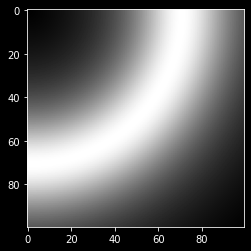

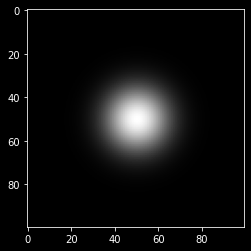

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


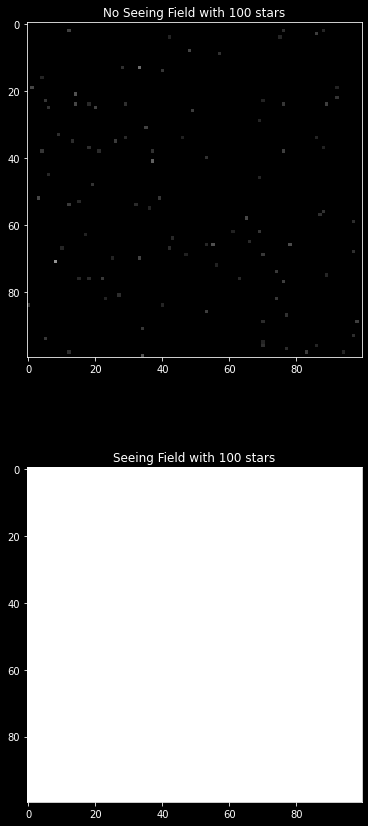

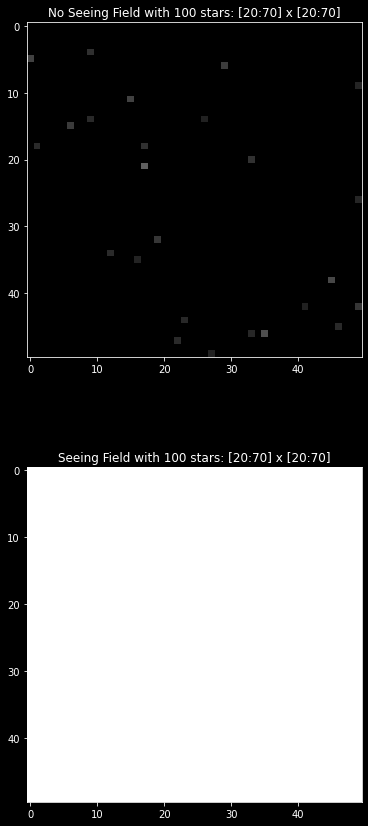

In [381]:
def lorentzian(n,xs,ys,sigma=0.9):
	a = 2.4 * sigma	 
	rs = np.sqrt(xs**2 + ys**2)
	c = lambda r : (rs**2+a**2)/( (r-rs)**2 + a**2 )
	return np.array([[c(np.sqrt(i**2+j**2)) for i in range(n) ] for j in range(n)])



def atm_seeing(f):
	n = len(f)
	field = f[:,:,0]
	field = fftconvolve(field,lorentzian(n,int(n/2),int(n/2)),mode='same')
	for i in range(3):
		f[:,:,i] = field
	return f
plt.figure(1)
plt.imshow(lorentzian(N,int(N/2),int(N/2),sigma=10),cmap='gray')
plt.figure(2)
plt.imshow(gaussian(N,int(N/2),int(N/2),sigma=10),cmap='gray')
plt.show()

fig1, (img_field, img_field_seeing) = plt.subplots(2,1,figsize=(6,15))
fig2, ( img_zoom, img_zoom_seeing)  = plt.subplots(2,1,figsize=(6,15))

F, S = initialize()
img_field.imshow(F)
img_field.set_title(f'No Seeing Field with {M} stars')
img_zoom.imshow(F[20:70,20:70,:])
img_zoom.set_title(f'No Seeing Field with {M} stars: [20:70] x [20:70]')

F_s = atm_seeing(F)
img_field_seeing.imshow(F_s)
img_field_seeing.set_title(f'Seeing Field with {M} stars')
img_zoom_seeing.imshow(F_s[20:70,20:70,:])
img_zoom_seeing.set_title(f'Seeing Field with {M} stars: [20:70] x [20:70]')

plt.show()